In [ ]:
!pip install findspark


In [ ]:
!pip install pyspark


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, NaiveBayes, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


spark = SparkSession.builder.appName('Stroke_Prediction').getOrCreate()
spark

In [ ]:
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
df_stroke=spark.read.csv("/content/healthcare-dataset-stroke-data.csv",header=True, inferSchema=True)
df_stroke.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
df_stroke.head()

Row(id=9046, gender='Male', age=67.0, hypertension=0, heart_disease=1, ever_married='Yes', work_type='Private', Residence_type='Urban', avg_glucose_level=228.69, bmi='36.6', smoking_status='formerly smoked', stroke=1)

In [ ]:
df_stroke.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
df_stroke.count()
print("The number of rows:", df_stroke.count())

len(df_stroke.columns)
print("The number of columns:", len(df_stroke.columns))


The number of rows: 5110
The number of columns: 12


In [ ]:
df_stroke.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [ ]:
df_stroke.groupBy(df_stroke['stroke']).count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



Data Preprocessing stage

Filling in the missing values in the "BMI" column using mean bmi value

In [ ]:
# Cast 'bmi' column to float type
df_stroke = df_stroke.withColumn("bmi", df_stroke["bmi"].cast(FloatType()))

# Filter out rows with non-numeric values in the 'bmi' column
df_stroke_filtered = df_stroke.filter(df_stroke["bmi"].isNotNull())

# Print unique values in the 'bmi' column
unique_bmi_values = df_stroke_filtered.select("bmi").distinct().collect()
print("Unique values in the 'bmi' column:")
for val in unique_bmi_values:
    print(val)

Unique values in the 'bmi' column:
Row(bmi=22.200000762939453)
Row(bmi=18.0)
Row(bmi=18.5)
Row(bmi=26.899999618530273)
Row(bmi=50.900001525878906)
Row(bmi=13.199999809265137)
Row(bmi=15.300000190734863)
Row(bmi=61.20000076293945)
Row(bmi=50.599998474121094)
Row(bmi=34.099998474121094)
Row(bmi=71.9000015258789)
Row(bmi=42.900001525878906)
Row(bmi=52.29999923706055)
Row(bmi=15.100000381469727)
Row(bmi=11.300000190734863)
Row(bmi=20.100000381469727)
Row(bmi=16.399999618530273)
Row(bmi=57.20000076293945)
Row(bmi=24.899999618530273)
Row(bmi=39.900001525878906)
Row(bmi=34.400001525878906)
Row(bmi=42.5)
Row(bmi=13.699999809265137)
Row(bmi=48.900001525878906)
Row(bmi=28.5)
Row(bmi=36.70000076293945)
Row(bmi=34.29999923706055)
Row(bmi=39.0)
Row(bmi=30.0)
Row(bmi=31.899999618530273)
Row(bmi=17.0)
Row(bmi=39.20000076293945)
Row(bmi=27.799999237060547)
Row(bmi=29.100000381469727)
Row(bmi=31.200000762939453)
Row(bmi=45.20000076293945)
Row(bmi=15.199999809265137)
Row(bmi=29.899999618530273)
Row(bmi=

In [ ]:
# Calculate mean BMI value
mean_bmi = df_stroke_filtered.select(mean(col("bmi"))).collect()[0][0]
print("Mean BMI value used for filling missing values:", mean_bmi)

# Fill missing values in 'bmi' column with mean value
df_stroke = df_stroke.fillna(mean_bmi, subset=["bmi"])
df_stroke = df_stroke.withColumn("bmi", col("bmi").cast("integer"))

# Show the dataframe with filled missing values in 'bmi' column
df_stroke.show(10)

Mean BMI value used for filling missing values: 28.89323691268831
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69| 36|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| 28|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92| 32|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23| 34|         smokes|    

Identifying missing value in columns

In [ ]:
missing_values_count = df_stroke.select([count(when((col(c).isNull()) | (col(c) == "") | (col(c) == "N/A") | (col(c) == "NA") | isnan(col(c)), c)).alias(c) for c in df_stroke.columns])
missing_values_count.show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [ ]:
bmi_missing_value = df_stroke.select(count(when((isnan("bmi") | col("bmi").isNull() | (col("bmi") == "") | (col("bmi") == "N/A") | (col("bmi") == "NA")), "bmi"))).collect()[0][0]
print("Missing count in 'bmi' column:", bmi_missing_value)

Missing count in 'bmi' column: 0


In [ ]:
# Print the mean BMI value used for filling missing values
print("Mean BMI value used for filling missing values:", mean_bmi)

# Check for null values in other columns
other_null_counts = df_stroke.select([count(when(col(c).isNull(), c)).alias(c) for c in df_stroke.columns if c != 'bmi']).collect()[0]
print("Null counts in other columns:")
for column, null_count in zip(df_stroke.columns, other_null_counts):
    print(f"{column}: {null_count}")

Mean BMI value used for filling missing values: 28.89323691268831
Null counts in other columns:
id: 0
gender: 0
age: 0
hypertension: 0
heart_disease: 0
ever_married: 0
work_type: 0
Residence_type: 0
avg_glucose_level: 0
bmi: 0
smoking_status: 0


Removal of 'id' column

In [ ]:
df_stroke= df_stroke.drop('id')

In [ ]:
df_stroke.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69| 36|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| 28|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92| 32|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23| 34|         smokes|     1|
| 1665|Female|79.0|           1|            0|         Yes|Sel

In [ ]:
df_stroke.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: integer (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



Label encoding

In [ ]:

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep")
            for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]

# Apply StringIndexers in pipeline
pipeline = Pipeline(stages=indexers)
df_stroke_indexed = pipeline.fit(df_stroke).transform(df_stroke)

# Apply OneHotEncoder for gender index column
encoder = OneHotEncoder(inputCols=["gender_index"], outputCols=["gender_encoded"])
model = encoder.fit(df_stroke_indexed)
df_stroke_encoded = model.transform(df_stroke_indexed)

# VectorAssembler for combining features
input_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_encoded']
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df_stroke_assembled = assembler.transform(df_stroke_encoded)

# Show the dataframe with gender one-hot encoded
df_stroke_assembled.show(10)


+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+------------+------------------+---------------+--------------------+--------------------+--------------+--------------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|bmi| smoking_status|stroke|gender_index|ever_married_index|work_type_index|Residence_type_index|smoking_status_index|gender_encoded|            features|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+---+---------------+------+------------+------------------+---------------+--------------------+--------------------+--------------+--------------------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69| 36|formerly smoked|     1|         1.0|               0.0|            0.0|                 0.0|                 2

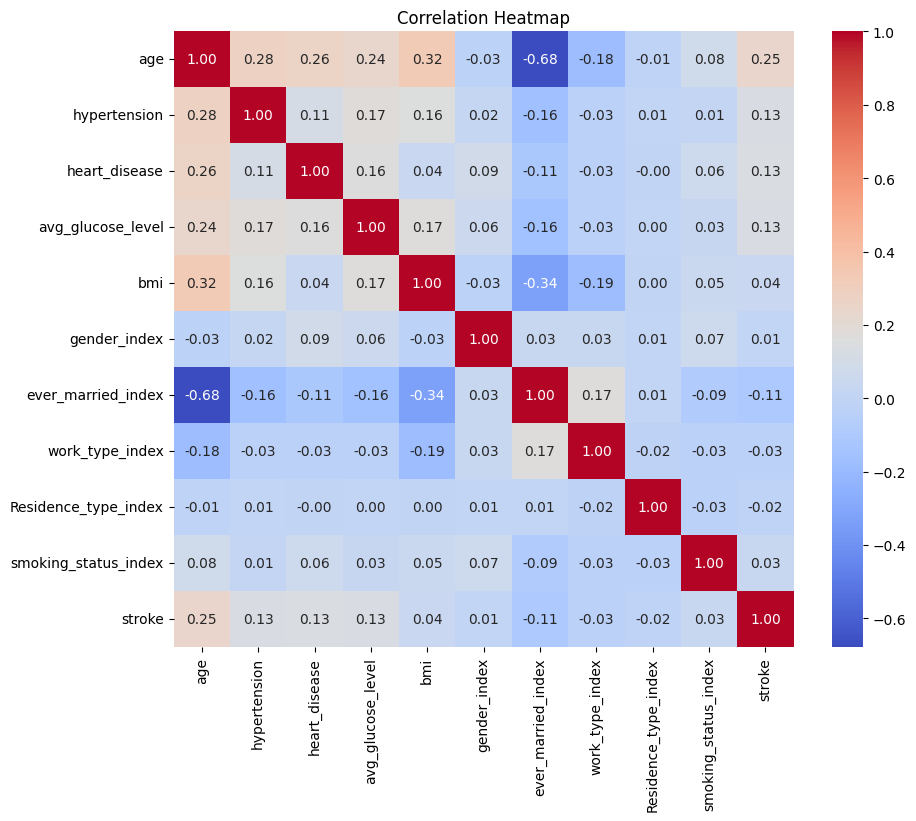

In [ ]:
# Correlation matrix heatmap

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df_selected.toPandas()

# Calculate correlation matrix
corr_matrix = df_pandas.corr()

# Plotting correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Model Scaling

In [ ]:
from pyspark.ml.feature import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Fit the scaler to the data
scaler_model = scaler.fit(df_stroke_assembled)

# Transform the data
df_stroke_scaled = scaler_model.transform(df_stroke_assembled)

# Show the dataframe with scaled features
df_stroke_scaled.select("scaled_features").show(10, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                   |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1.0513313991807545,-0.3285697091631481,4.184622475198168,2.706110616938918,0.9844699702410818,-1.1893935187116556,1.1898733258610663,-0.013989092759813321]      |
|[0.7859931540178339,-0.3285697091631481,-0.23892341811226608,2.1213509400949206,-0.05604743974535602,0.840600095388732,-0.8402611299486329,-0.013989092759813321] |
|[1.6262309303670828,-0.3285697091631481,4.184622475198168,-0.005027809274735759,0.4642112652478629,-1.1893935187116556,1.1898733258610663,-0.013989092759813321]  |
|[0.255316

Model Training and Testing

In [ ]:
# Split the data into training and testing sets
(train_data, test_data) = df_stroke_scaled.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Train Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="stroke", seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="stroke")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Train SVM model
svm = LinearSVC(featuresCol="features", labelCol="stroke")
svm_model = svm.fit(train_data)
svm_predictions = svm_model.transform(test_data)

# Train Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="stroke")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# Evaluate models
evaluator = BinaryClassificationEvaluator(labelCol="stroke", metricName="areaUnderROC")
rf_accuracy = evaluator.evaluate(rf_predictions)
lr_accuracy = evaluator.evaluate(lr_predictions)
svm_accuracy = evaluator.evaluate(svm_predictions)
nb_accuracy = evaluator.evaluate(nb_predictions)

# Display accuracies
print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)


Random Forest Accuracy: 0.8612894844289373
Logistic Regression Accuracy: 0.8631268327085132
SVM Accuracy: 0.802123158011954
Naive Bayes Accuracy: 0.18494116773690647


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluation metrics
def evaluate_model(predictions):
    # Calculate accuracy
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
    accuracy = accuracy_evaluator.evaluate(predictions)

    # Calculate precision
    precision_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
    precision = precision_evaluator.evaluate(predictions)

    # Calculate recall
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedRecall")
    recall = recall_evaluator.evaluate(predictions)

    # Calculate F1-score
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(predictions)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)

# Evaluate models
print("Random Forest Metrics:")
evaluate_model(rf_predictions)

print("\nLogistic Regression Metrics:")
evaluate_model(lr_predictions)

print("\nSVM Metrics:")
evaluate_model(svm_predictions)

print("\nNaive Bayes Metrics:")
evaluate_model(nb_predictions)


Random Forest Metrics:
Accuracy: 0.9574468085106383
Precision: 0.9167043911272069
Recall: 0.9574468085106383
F1 Score: 0.9366327474560593

Logistic Regression Metrics:
Accuracy: 0.9574468085106383
Precision: 0.9167043911272069
Recall: 0.9574468085106383
F1 Score: 0.9366327474560593

SVM Metrics:
Accuracy: 0.9574468085106383
Precision: 0.9167043911272069
Recall: 0.9574468085106383
F1 Score: 0.9366327474560593

Naive Bayes Metrics:
Accuracy: 0.8074974670719351
Precision: 0.9343014094427265
Recall: 0.8074974670719351
F1 Score: 0.8603494918476274
